In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import os
os.chdir('../')
!pwd

/home/jupyter/deep_learning-systems-project


In [3]:
torch.manual_seed(0)
np.random.seed(0)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [4]:
from models.taskonomy_models import resnet18_taskonomy

#converged model without pruning
checkpoint = torch.load('backup/saved/base_model/savecheckpoint/checkpoint_latest_400.pth.tar')

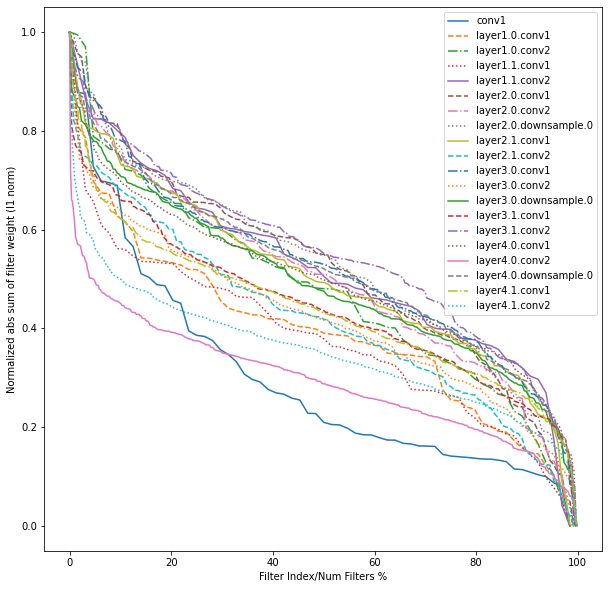

In [5]:

plt.figure(figsize=(10,10))

def get_model():
    model = resnet18_taskonomy(pretrained=False, tasks=['autoencoder', 'normal', 'reshading'])
    model = torch.nn.DataParallel(model)
    model.load_state_dict(checkpoint['state_dict'])
    return model
    #load pre-trained weights

def sensitivity_analysis():
    #running experiments described in https://arxiv.org/pdf/1608.08710.pdf
    #doing this for convolution layers only as described in paper
    model = get_model().module
    backbone = model.encoder
    modules = [module for name, module in backbone.named_modules() if isinstance(module, torch.nn.Conv2d)]
    names = [name for name, module in backbone.named_modules() if isinstance(module, torch.nn.Conv2d)]
    linestyles = ['-', '--', '-.', ':']

    for idx, module in enumerate(modules):
        num_filters = module.weight.shape[0]
        norms = np.absolute(torch.norm(module.weight, p=1, dim=(1,2,3)).detach().cpu().numpy())
        order = np.argsort(-1*norms) #sort
        normalized_abs_norm = (norms[order]-norms[order][-1])/(norms[order][0]-norms[order][-1]) #0-1 min-max normalization
        filter_idx_over_num_filters = 100*np.arange(0, num_filters)/num_filters
        plt.plot(filter_idx_over_num_filters, normalized_abs_norm, linestyle=linestyles[idx%4])
    plt.legend(names)
    plt.xlabel('Filter Index/Num Filters %')
    plt.ylabel('Normalized abs sum of filter weight (l1 norm)')
    plt.show()
    
    
    #prune smallest filters and measure accuracy
    #currently focusing only on 
        
        
sensitivity_analysis()

In [6]:
import pandas

In [7]:
normal_df = pandas.read_csv('results/sensitivity_analysis/normal.csv')
reshading_df = pandas.read_csv('results/sensitivity_analysis/reshading.csv')

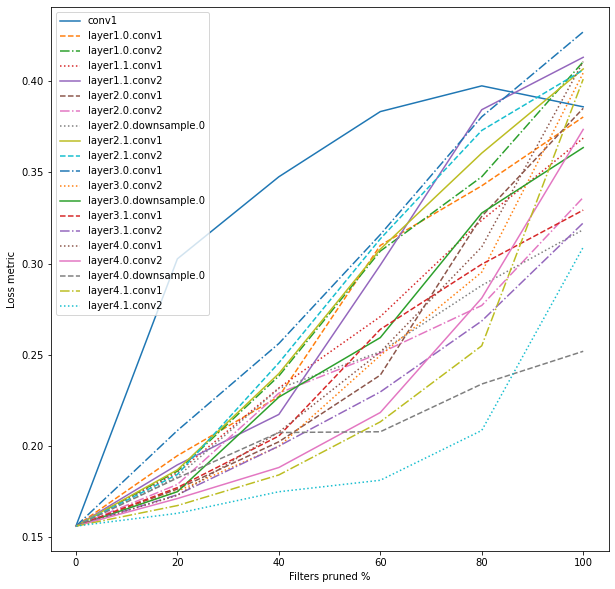

In [8]:
plt.figure(figsize=(10,10))

legend = normal_df.iloc[:, 1].values
measurements = normal_df.iloc[:, 2:8].values
x_vals = [0, 20, 40, 60, 80, 100]
linestyles = ['-', '--', '-.', ':']
for i in range(len(measurements)):
    plt.plot(x_vals, measurements[i], linestyle=linestyles[i%4])
plt.xlabel('Filters pruned %')
plt.ylabel('Loss metric')
plt.legend(legend)
plt.show()
    

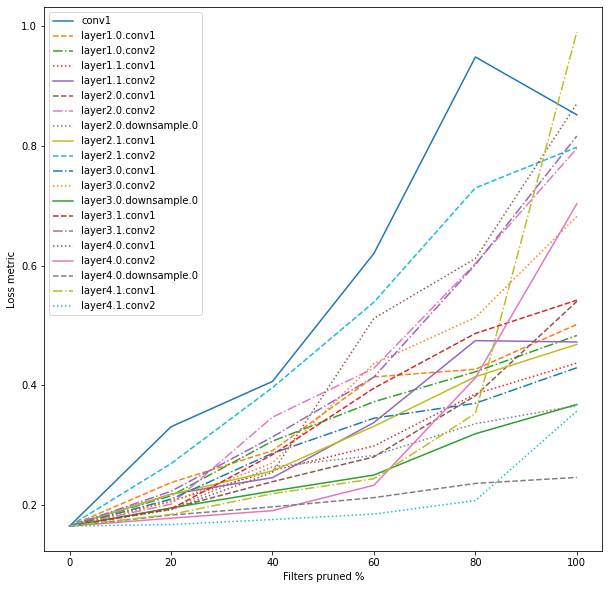

In [9]:
plt.figure(figsize=(10,10))

legend = reshading_df.iloc[:, 1].values
measurements = reshading_df.iloc[:, 2:8].values
x_vals = [0, 20, 40, 60, 80, 100]
linestyles = ['-', '--', '-.', ':']
for i in range(len(measurements)):
    plt.plot(x_vals, measurements[i], linestyle=linestyles[i%4])
plt.xlabel('Filters pruned %')
plt.ylabel('Loss metric')
plt.legend(legend)
plt.show()